In [40]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 300
X, y = make_classification(n_samples = 2000, n_features = n_features, n_informative = 100, n_clusters_per_class=3, n_redundant=100, n_repeated=20, flip_y=0.05, random_state=2, class_sep=2)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

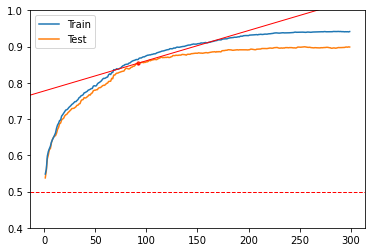

AT (92, 0.8543, 0.17789333333333338) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:28.081069500


In [5]:
RANDOM_SELECTION(0.00001)

# SVM-RFE

In [41]:
@time_func
def SVM_RFE_W_STEP(mode = 'const', step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6):
    data.kernel = kernel
    #data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    kf = KFold(n_splits=7, shuffle=True)

    def Xresample(X0):
        return resample(X0, replace=False, n_samples = int(X0.shape[0]*percentage))

    if mode == 'outsample':
        index = [(Xresample(train_index), test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe, index)
    if mode == 'sample':
        index = [(train_index, test_index, step, percentage) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_sampling, index)

    #scores = list(map(data.svm_rfe_dynamic_step, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(mode, C, step, percentage)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

const 1e-05 10 1.0


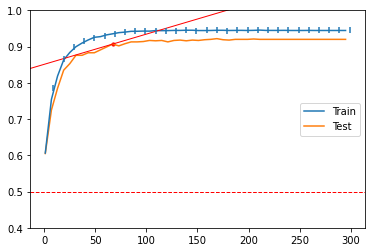

AT (67, 0.9069873788183649, 0.11907676361197475) WITH 30 ITERATIONS IN 0.9873769623892648 SECONDS : 0.0010202879122391318
__main__.SVM_RFE_W_STEP - 00:00:05.224241000
const 0.0001 10 0.5


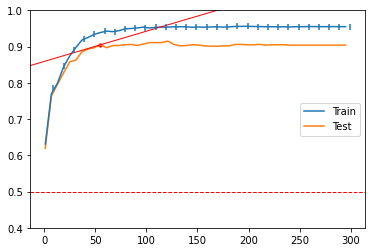

AT (55, 0.9049964120386654, 0.11266953703573433) WITH 30 ITERATIONS IN 1.240619352885655 SECONDS : 0.004178788256365583
__main__.SVM_RFE_W_STEP - 00:00:05.821504400


((55, 0.9049964120386654, 0.11266953703573433), 1.240619352885655)

In [23]:
SVM_RFE_W_STEP('const', C=0.00001, percentage=1.0)
SVM_RFE_W_STEP('const', C=0.0001, percentage=0.5)

outsample 1e-05 10 1.0


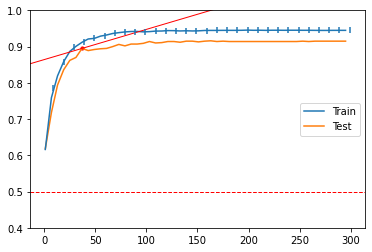

AT (37, 0.895027507703564, 0.1086446605038155) WITH 30 ITERATIONS IN 0.9725386074611119 SECONDS : 0.0016567857236047846
__main__.SVM_RFE_W_STEP - 00:00:05.317321100
outsample 0.0001 10 1.0


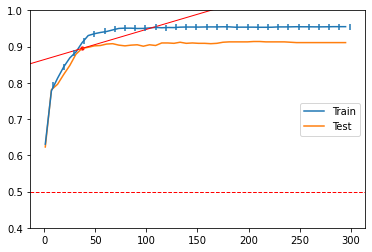

AT (37, 0.8950345429218667, 0.10863903232917332) WITH 30 ITERATIONS IN 1.249631064278739 SECONDS : 0.003887868590317228
__main__.SVM_RFE_W_STEP - 00:00:06.053830800
outsample 0.001 10 1.0


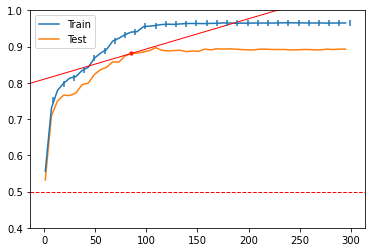

AT (85, 0.8809992824077331, 0.15186724074048022) WITH 30 ITERATIONS IN 1.7991698128836495 SECONDS : 0.010928406864478551
__main__.SVM_RFE_W_STEP - 00:00:07.814896200
outsample 0.01 10 1.0


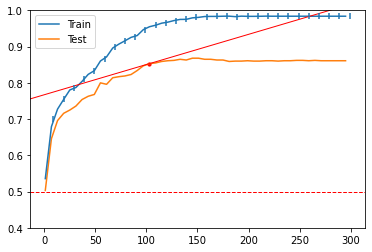

AT (103, 0.852992078344191, 0.18627300399131386) WITH 30 ITERATIONS IN 2.6048204558236256 SECONDS : 0.015343321785271466
__main__.SVM_RFE_W_STEP - 00:00:09.955619700
outsample 0.1 10 1.0


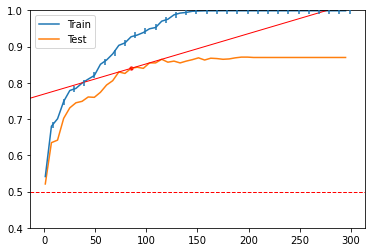

AT (85, 0.8399980301388753, 0.18466824255556644) WITH 30 ITERATIONS IN 9.914652517863683 SECONDS : 2.331683649670687
__main__.SVM_RFE_W_STEP - 00:00:30.910090600
outsample 1e-05 10 0.5


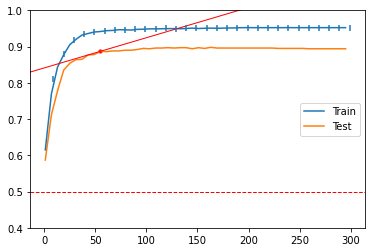

AT (55, 0.887035499711556, 0.12703826689742184) WITH 30 ITERATIONS IN 0.30885519300188335 SECONDS : 0.00010266503153968876
__main__.SVM_RFE_W_STEP - 00:00:03.633902300
outsample 0.0001 10 0.5


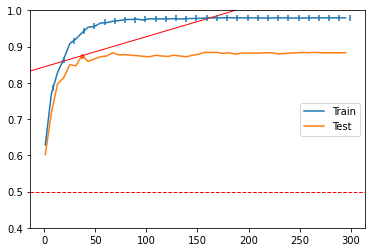

AT (37, 0.8749841707588188, 0.1246793300596116) WITH 30 ITERATIONS IN 0.42235054288591656 SECONDS : 0.00025841011840932004
__main__.SVM_RFE_W_STEP - 00:00:04.159171700
outsample 0.001 10 0.5


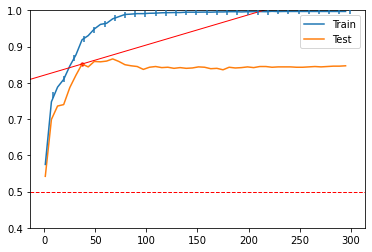

AT (37, 0.8519790069085843, 0.14308346113979925) WITH 30 ITERATIONS IN 0.4974250112261091 SECONDS : 0.0004210532273534728
__main__.SVM_RFE_W_STEP - 00:00:04.298137300
outsample 0.01 10 0.5


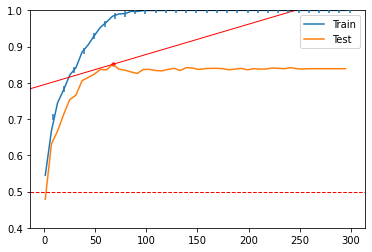

AT (67, 0.8509940763461891, 0.1638714055897154) WITH 30 ITERATIONS IN 2.1062697683061873 SECONDS : 0.12961241225352937
__main__.SVM_RFE_W_STEP - 00:00:08.781495200
outsample 0.1 10 0.5


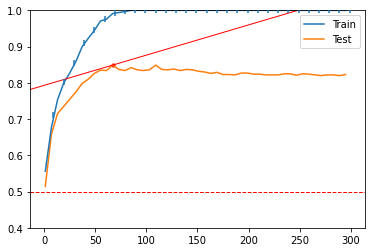

AT (67, 0.8490101447847928, 0.16545855083883246) WITH 30 ITERATIONS IN 2.2790516104016985 SECONDS : 1.2956250484093987
__main__.SVM_RFE_W_STEP - 00:00:11.072377400
outsample 1e-05 10 0.2


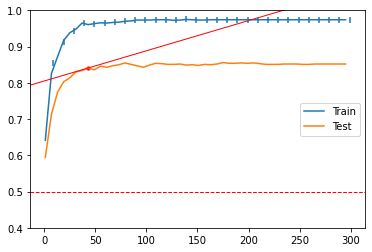

AT (43, 0.8409688902646649, 0.15589155445493474) WITH 30 ITERATIONS IN 0.11929873057774135 SECONDS : 2.5676950687683327e-05
__main__.SVM_RFE_W_STEP - 00:00:02.969671200
outsample 0.0001 10 0.2


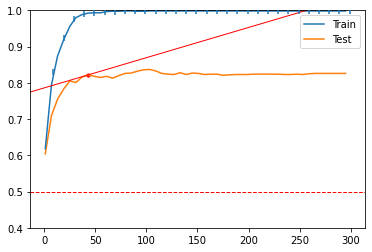

AT (43, 0.8219526951921319, 0.1711045105129612) WITH 30 ITERATIONS IN 0.16660809516906738 SECONDS : 0.00020446793600318154
__main__.SVM_RFE_W_STEP - 00:00:03.059578400
outsample 0.001 10 0.2


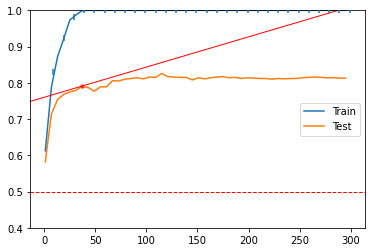

AT (37, 0.791054016406129, 0.19182345354176344) WITH 30 ITERATIONS IN 0.48195855958121164 SECONDS : 0.004834397859581815
__main__.SVM_RFE_W_STEP - 00:00:03.906925800
outsample 0.01 10 0.2


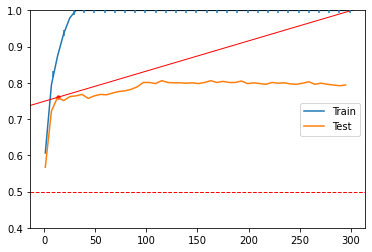

AT (13, 0.759930210634436, 0.20072249815911786) WITH 30 ITERATIONS IN 2.4920332772391185 SECONDS : 0.2019759251606214
__main__.SVM_RFE_W_STEP - 00:00:09.861022500
outsample 0.1 10 0.2


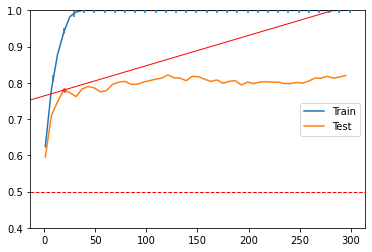

AT (19, 0.7799876180157871, 0.188676572254037) WITH 30 ITERATIONS IN 0.20771329743521555 SECONDS : 0.000680980561773307
__main__.SVM_RFE_W_STEP - 00:00:03.231925700


In [42]:
model_selection = {}
for p in [1.0, 0.5, 0.2]:
    for C in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
        model_selection[C, p] = SVM_RFE_W_STEP('outsample', C=C, percentage=p)

In [43]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} &    37 & 89.50\% & 0.109 &    55 & 88.70\% & 0.127 &    43 & 84.10\% & 0.156\\
\textbf{0.000100} &    37 & 89.50\% & 0.109 &    37 & 87.50\% & 0.125 &    43 & 82.20\% & 0.171\\
\textbf{0.001000} &    85 & 88.10\% & 0.152 &    37 & 85.20\% & 0.143 &    37 & 79.11\% & 0.192\\
\textbf{0.010000} &   103 & 85.30\% & 0.186 &    67 & 85.10\% & 0.164 &    13 & 75.99\% & 0.201\\
\textbf{0.100000} &    85 & 84.00\% & 0.185 &    67 & 84.90\% & 0.165 &    19 & 78.00\% & 0.189\\


In [44]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} & 0:00.972 & 0:00.308 & 0:00.119\\
\textbf{0.000100} & 0:01.249 & 0:00.422 & 0:00.166\\
\textbf{0.001000} & 0:01.799 & 0:00.497 & 0:00.481\\
\textbf{0.010000} & 0:02.604 & 0:02.106 & 0:02.492\\
\textbf{0.100000} & 0:09.914 & 0:02.279 & 0:00.207\\


sample 1e-05 10 0.5


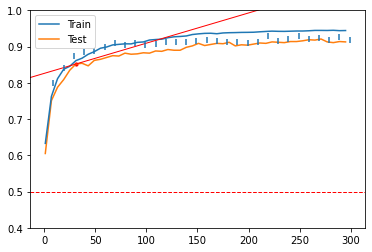

AT (31, 0.85199307734519, 0.13907220479051463) WITH 30 ITERATIONS IN 0.30341931751796175 SECONDS : 0.00010880539757032907
__main__.SVM_RFE_W_STEP - 00:00:04.781007200
sample 0.0001 10 0.5


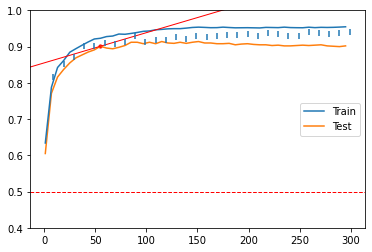

AT (55, 0.9009652319511474, 0.11589448110574874) WITH 30 ITERATIONS IN 0.31543077741350445 SECONDS : 0.0001546281981722577
__main__.SVM_RFE_W_STEP - 00:00:05.109729400
sample 0.001 10 0.5


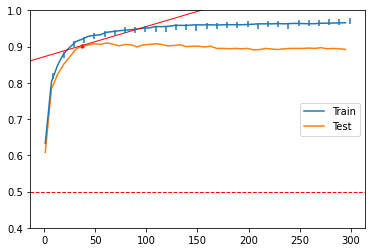

AT (37, 0.9030124804772692, 0.1022566822848513) WITH 30 ITERATIONS IN 0.33176534516470774 SECONDS : 8.788560115840947e-05
__main__.SVM_RFE_W_STEP - 00:00:05.326071800
sample 0.01 10 0.5


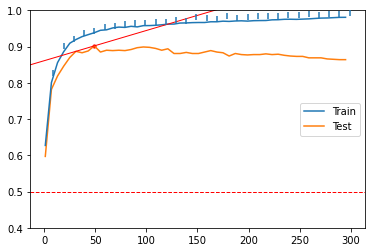

AT (49, 0.9019783033867542, 0.1110840239572633) WITH 30 ITERATIONS IN 0.3761186259133475 SECONDS : 9.942864144296455e-05
__main__.SVM_RFE_W_STEP - 00:00:06.822448500
sample 0.1 10 0.5


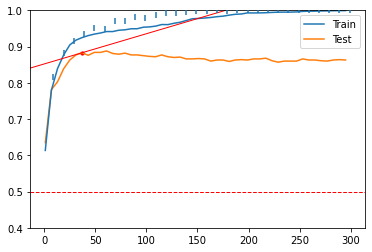

AT (37, 0.8830324604972491, 0.11824069826886735) WITH 30 ITERATIONS IN 0.4993175779070173 SECONDS : 0.00010642847180916965
__main__.SVM_RFE_W_STEP - 00:00:19.541322800
sample 1e-05 10 0.2


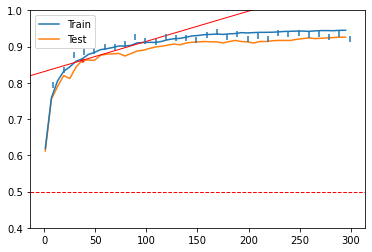

AT (37, 0.8620393690816225, 0.13503517140136867) WITH 30 ITERATIONS IN 0.13050201960972377 SECONDS : 0.00015658226890518192
__main__.SVM_RFE_W_STEP - 00:00:04.397314200
sample 0.0001 10 0.2


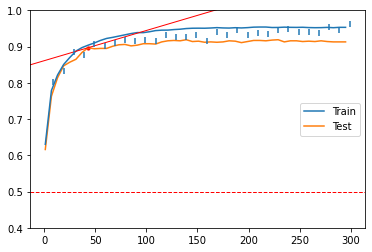

AT (43, 0.8970044040466575, 0.11106314342934069) WITH 30 ITERATIONS IN 0.12943094117300852 SECONDS : 6.710252344474815e-05
__main__.SVM_RFE_W_STEP - 00:00:05.003359600
sample 0.001 10 0.2


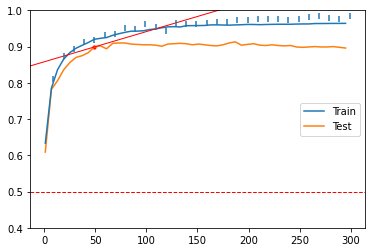

AT (49, 0.8989601947348426, 0.11349851087879262) WITH 30 ITERATIONS IN 0.14556612287248885 SECONDS : 2.796684876390215e-05
__main__.SVM_RFE_W_STEP - 00:00:05.364406700
sample 0.01 10 0.2


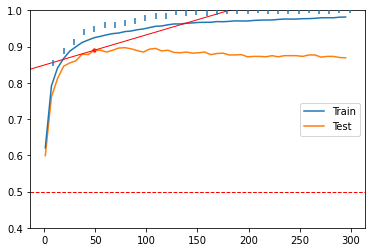

AT (49, 0.8899902913987422, 0.12067443354767293) WITH 30 ITERATIONS IN 0.1663710389818464 SECONDS : 5.890579401164694e-05
__main__.SVM_RFE_W_STEP - 00:00:06.900390900
sample 0.1 10 0.2


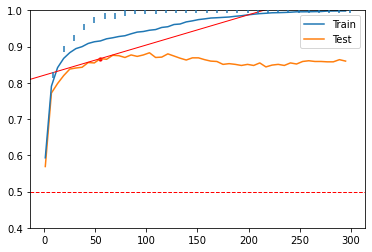

AT (55, 0.866978092330205, 0.14308419280250273) WITH 30 ITERATIONS IN 0.26257174355643137 SECONDS : 3.28148154870419e-05
__main__.SVM_RFE_W_STEP - 00:00:21.579169100
sample 1e-05 10 0.1


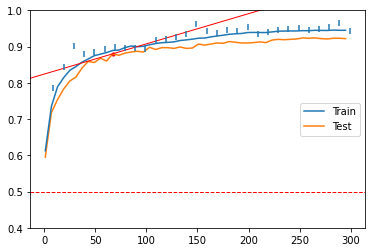

AT (67, 0.8800565631551546, 0.140621416142543) WITH 30 ITERATIONS IN 0.10105095590863909 SECONDS : 2.9190246564490843e-05
__main__.SVM_RFE_W_STEP - 00:00:04.563647600
sample 0.0001 10 0.1


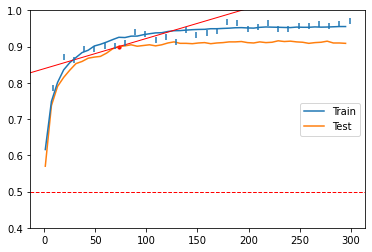

AT (73, 0.9000014070436605, 0.12866554103173827) WITH 30 ITERATIONS IN 0.09714123180934361 SECONDS : 3.237744386538276e-05
__main__.SVM_RFE_W_STEP - 00:00:04.962968200
sample 0.001 10 0.1


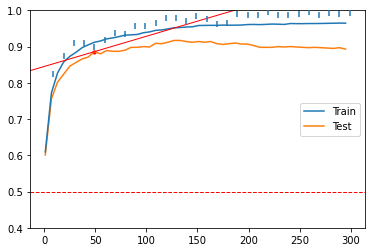

AT (49, 0.8860294634942522, 0.12384309587126496) WITH 30 ITERATIONS IN 0.0989912578037807 SECONDS : 3.330835898869199e-06
__main__.SVM_RFE_W_STEP - 00:00:05.523452000
sample 0.01 10 0.1


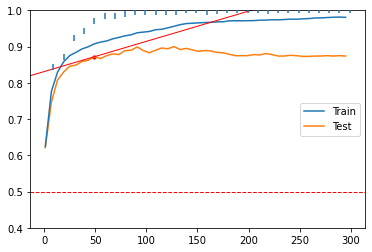

AT (49, 0.8720223438533298, 0.13504879158400285) WITH 30 ITERATIONS IN 0.11427780560084752 SECONDS : 5.3289932768110504e-05
__main__.SVM_RFE_W_STEP - 00:00:07.259579800
sample 0.1 10 0.1


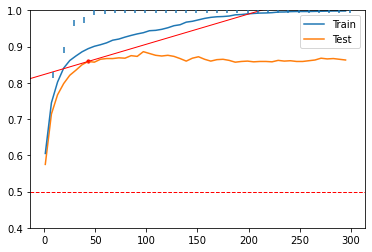

AT (43, 0.8590494013029224, 0.14142714562432876) WITH 30 ITERATIONS IN 0.17071410587855748 SECONDS : 3.418488276742098e-05
__main__.SVM_RFE_W_STEP - 00:00:20.914131100


In [20]:
model_selection = {}
for step in [0.5, 0.2, 0.1]:
    for C in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
        model_selection[C, step] = SVM_RFE_W_STEP('sample', C=C, percentage=step)

In [21]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.5: 1, 0.2: 2, 0.1: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} &    31 & 85.20\% & 0.139 &    37 & 86.20\% & 0.135 &    67 & 88.01\% & 0.141\\
\textbf{0.000100} &    55 & 90.10\% & 0.116 &    43 & 89.70\% & 0.111 &    73 & 90.00\% & 0.129\\
\textbf{0.001000} &    37 & 90.30\% & 0.102 &    49 & 89.90\% & 0.113 &    49 & 88.60\% & 0.124\\
\textbf{0.010000} &    49 & 90.20\% & 0.111 &    49 & 89.00\% & 0.121 &    49 & 87.20\% & 0.135\\
\textbf{0.100000} &    37 & 88.30\% & 0.118 &    55 & 86.70\% & 0.143 &    43 & 85.90\% & 0.141\\


In [22]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.5: 1, 0.2: 2, 0.1: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} & 0:00.303 & 0:00.130 & 0:00.101\\
\textbf{0.000100} & 0:00.315 & 0:00.129 & 0:00.097\\
\textbf{0.001000} & 0:00.331 & 0:00.145 & 0:00.098\\
\textbf{0.010000} & 0:00.376 & 0:00.166 & 0:00.114\\
\textbf{0.100000} & 0:00.499 & 0:00.262 & 0:00.170\\
